In [1]:
import math
import random
import time
import matplotlib.pyplot as plt 
import datetime
from multiprocessing import Pool
from itertools import combinations, product
from statistics import mean, stdev
from itertools import combinations
from numpy import log, append, setdiff1d, array
from collections import deque # Cola FIFO para la lista tabú
from numpy import argsort # Ordenar lista por indices (GRASP)
from functools import partial 
import matplotlib
import matplotlib.pyplot as plt
from heapq import nsmallest # Seleccion torneo
verbose = False

# Funciones comunes

In [2]:
def leeFichero(nombreFichero ='tsp/a280.tsp'):
    rutaFichero = './tsp/'
    extension = '.tsp'
    fichero = open(rutaFichero + nombreFichero + extension, 'r')
    array_puntos = []

    # Saltamos las cabeceras del fichero #
    for i in range(6):
        fichero.readline()

    for line in fichero:
        try:
            array_temp = line.replace('   ', ' ').replace('  ', ' ').replace('\n', '').split(' ')
            array_temp = [float(item) for item in array_temp if item]

            if(len(array_temp) > 1):
                array_puntos.append(array_temp)
        except:
            pass

    fichero.close()

    return array_puntos

In [3]:
def getDistancia(p1, p2):
    xd = p1[1] - p2[1]
    yd = p1[2] - p2[2]
    
    dij = round(math.sqrt(xd*xd + yd*yd))
    
    return dij

In [4]:
def getMDistancias(nodos):
   
    distancias = [[0]*len(nodos) for i in range(len(nodos))]
    
    for i in range(len(nodos)):
        for j in range(len(nodos)):
            
            if(i==j):
                dij = 0 # Distancia a sí mismo infinita
            else:
                dij = getDistancia(nodos[i], nodos[j])
                
            distancias[i][j] = dij
            
    return distancias

In [5]:
def pintaCamino(camino, nodos, titulo):
    
    x = []
    y = []
    
    for i in range(0, len(camino)-1):
        
        x.append(nodos[camino[i]-1][1])
        y.append(nodos[camino[i]-1][2])
        
    plt.figure(figsize=(12,12))    
    plt.title(titulo)
    plt.scatter(x, y, color='green') 
    
    for i in range(len(x)):
        if(i < len(x)-1):
            plt.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i], head_width=1, length_includes_head=True)
        else:
             plt.arrow(x[i], y[i], x[0] - x[i], y[0] - y[i], head_width=1, length_includes_head=True)
                
    # Punto rojo inicial
    plt.plot(x[0],y[0], marker='o',
     markerfacecolor='red', markersize=12)
                

In [6]:
def getCosteCamino(camino, distancias, verbose=False):
    coste = 0
    
    for i in range(0, len(camino)-1):
        dij = distancias[camino[i]][camino[i+1]]
        coste += dij # Sumamos la distancia de un nodo al siguiente
        if(verbose):
            print(f"Acumulando Distancia {camino[i]} -> {camino[i+1]} = {dij}")
        
        
    dij = distancias[camino[-1]][camino[0]] #Sumamos la distancia del ultimo al primero
    coste += dij
    if(verbose):
            print(f"Acumulando Distancia {camino[-1]} -> {camino[0]} = {dij}")
    
    return coste

In [7]:
def getCostePivotes(distancias, caminoAnt, costeAnt, piv1, piv2):
      
    caminoAnt1 = [caminoAnt[piv1-1], caminoAnt[piv1]]
    if(piv1 != len(distancias)-1):
        caminoAnt1.append(caminoAnt[piv1+1])
    else:
        # Pivote es el último elemento: último al primero
        caminoAnt1.append(caminoAnt[0])
        
    caminoAnt2 = [caminoAnt[piv2-1], caminoAnt[piv2]]
    if(piv2 != len(distancias)-1):
        caminoAnt2.append(caminoAnt[piv2+1])
    else:
        # Pivote es el último elemento: último al primero
        caminoAnt2.append(caminoAnt[0])
        
    caminoNuevo1 = caminoAnt1.copy()
    if caminoAnt[piv2] in caminoNuevo1:
        caminoNuevo1[caminoNuevo1.index(caminoAnt[piv2])] = caminoAnt[piv1]
    caminoNuevo1[1] = caminoAnt[piv2]
    
    
    caminoNuevo2 = caminoAnt2.copy()
    if caminoAnt[piv1] in caminoNuevo2:
        caminoNuevo2[caminoNuevo2.index(caminoAnt[piv1])] = caminoAnt[piv2]
    caminoNuevo2[1] = caminoAnt[piv1]
   
    #print("SubCaminos anteriores: ", caminoAnt1, caminoAnt2)
    #print("SubCaminos nuevos: ", caminoNuevo1, caminoNuevo2)
    
    return (costeAnt - distancias[caminoAnt1[0]][caminoAnt1[1]] - distancias[caminoAnt1[1]][caminoAnt1[2]] - distancias[caminoAnt2[0]][caminoAnt2[1]] - distancias[caminoAnt2[1]][caminoAnt2[2]] + distancias[caminoNuevo1[0]][caminoNuevo1[1]] +  distancias[caminoNuevo1[1]][caminoNuevo1[2]] + distancias[caminoNuevo2[0]][caminoNuevo2[1]] + distancias[caminoNuevo2[1]][caminoNuevo2[2]])
    

# Algoritmo Greedy

In [8]:
# Algoritmo Greedy
def algoritmoGreedy(distancias):
    
    caminoSolucion = [0] # Empezamos en el primer indice de nodo
    nodosPendientes = list(range(1,len(distancias[1]))) # Lista del segundo al ultimo indice de nodo
    
    while len(nodosPendientes) > 0: # Mientras queden nodos por visitar

        nodoActual = caminoSolucion[-1] # Partimos desde el útlimo nodo añadido
        minDistancia = distancias[nodoActual][nodosPendientes[0]] # Inicializamos la distancia del actual al primer pendiente
        nodoMinDistancia = nodosPendientes[0]
        
        for nodoVecino in nodosPendientes: # Recorremos todos los nodos pendientes y nos quedamos con el de menor distancia
            d = distancias[nodoActual][nodoVecino]
            
            if d < minDistancia:
                minDistancia = d
                nodoMinDistancia = nodoVecino
                
        caminoSolucion.append(nodoMinDistancia)
        nodosPendientes.remove(nodoMinDistancia)
        
    return caminoSolucion
    #return [indice+1 for indice in caminoSolucion] # + 1 a cada elemento (tiene que empezar por 1)

# Algoritmo Genético Básico

## Estructura de datos

In [9]:
class Cromosoma:
    
    # Métodos de clase
    def set_nodos_distancias(num_nodos, distancias):
        Cromosoma.num_nodos = num_nodos
        Cromosoma.distancias = distancias
    
    # Métodos de instancias
    
    # Operador minimo
    # https://stackoverflow.com/questions/3621826/python-minimum-of-a-list-of-instance-variables
    def __lt__(self, other):
        return self.coste < other.coste
    
    def __eq__(self, other):
        return self.camino == other.camino
    
    def __str__(self):
        return str(self.coste)
    
    def __repr__(self):
        return str(self.coste)
    
    # Se puede instanciar de 3 maneras:
    # Cromosoma(): solucion aleatoria no elite
    # Cromosoma(camino, coste): solucion y coste definidos, no elite
    def __init__(self, *args):
        
        if not Cromosoma.num_nodos or not Cromosoma.distancias:
            raise TypeError("No se ha inicializado el num nodos o las distancias para la clase Cromosoma") 
        
        if len(args) == 0:
            # Combinación aleatoria sin repeteción de nodos
            self.camino = random.sample(range(Cromosoma.num_nodos), Cromosoma.num_nodos) # Combinación aleatoria sin repeteción de nodos
            self.coste = getCosteCamino(self.camino, Cromosoma.distancias) 
            
        elif len(args) == 2:
            self.camino = args[0]
            self.coste = args[1]        
        else:
            raise TypeError("Número de argumentos no válido, solo 0 ó 2") 
            
    def set_camino(self, camino):
        self.camino = camino
        
    def set_coste(self, coste):
        self.camino = coste
        
    def get_camino(self):
        return self.camino
    
    def get_coste(self):
        return self.coste
        
    

In [10]:
class Poblacion:
    
    def __init__(self): 
        self.coste = 0
        self.media = 0
        self.individuos = []
#         self.elite = []
#         self.tam_elite = tam_elite

    def __eq__(self, other):
        return self.individuos == other.individuos

    
    def add(self, cromosoma):
        self.individuos.append(cromosoma)
        self.coste += cromosoma.coste
        self.media = self.coste / len(self.individuos)
        
        
#         if len(self.elite) < self.tam_elite:
#             self.elite.append(cromosoma)
#         # Si es mejor que el peor de los elites  
#         elif cromosoma < max(self.elite):
#             self.elite.remove(max(self.elite))
#             self.elite.append(cromosoma)
    
    def remove(self, cromosoma):
        self.individuos.remove(cromosoma)
        self.coste -= cromosoma.coste
        self.media = self.coste / len(self.individuos)
#         if cromosoma in self.elite:
#             self.elite.remove(cromosoma)
        del cromosoma
    

## Funciones auxiliares

In [11]:
# Número de posiciones en las que varían los nodos del individuo 1 y 2
# https://stackoverflow.com/questions/54172831/hamming-distance-between-two-strings-in-python
def distancia_hamming(indv1, indv2):
    return sum(nodo1 != nodo2 for nodo1, nodo2 in zip(indv1.camino, indv2.camino))

In [12]:
def seleccion_torneo(poblacion, k):
    
    # Seleccionar k individuos aleatorios
    individuos = random.sample(poblacion.individuos, k)
    
    # Devolver los dos mejores padres
    return nsmallest(2,individuos)

In [13]:
# Torneo restringido (RTS)
# Seleciona el individuo más parecido a hijo
# De entre k individuos aleatorios de la población
# Problema: no tiene en consideración si el seleccionado es mejor (ver WAMS)
def reemplazo_torneo(poblacion, k, hijo):
    
    # Si el peor individuo es una solución élite, se repite el torneo
    seguir = True
    intentos = 0
    while(seguir):
        # Seleccionar k individuos aleatorios
        individuos = random.sample(poblacion.individuos, k)
        
        # Lista ordenada según la distancia de hamming al hijo
        # https://stackoverflow.com/questions/27202942/sort-list-of-objects-by-return-of-object-method
        # https://stackoverflow.com/questions/22483867/how-to-pass-multiple-arguments-to-the-method-key-of-sorted
        individuos_ordenados = sorted(individuos, key=partial(distancia_hamming, indv2=hijo))
        
        # Elegimos al de menor distancia de hamming (más parecido al hijo)
        individuo_reemplazar = individuos_ordenados[0]
        
        # Controlar que no reemplace a uno mejor
        if hijo < individuo_reemplazar :
            # Devolver el individuo a reemplazar
            return individuo_reemplazar
#         # Si no, se sigue intentando
#         elif intentos < 3:
#             continue
        # Si no, no se produce reemplazo y se avanza a la creacion de otro hijo
        else:
            return None

In [14]:
# individuos = [Cromosoma([1,2,3,4],0), Cromosoma([1,2,4,3],1), Cromosoma([4,3,2,1],2)]
# hijo = Cromosoma([1,2,3,4],0)
# print(sorted(individuos, key=partial(distancia_hamming, indv2=hijo)))
# print(individuos[0])
# distancia_hamming(individuos[2], hijo)

In [15]:
# Operador de Cruce: basado en Orden OX
def cruce_OX(padre1, padre2, s, distancias):
    
    # Mantenemos una sublista del primer padre de tamaño s
    # Indices de la sublista
    pivote1 = int(random.randint(0, padre1.num_nodos-1))
    pivote2 = int(pivote1 + s)

        
    # Como no es cíclica, si se sale por la derecha, hay que limitarla
    if pivote2 > padre1.num_nodos:
        pivote2 = padre1.num_nodos
        
    sublista = padre1.camino[pivote1:pivote2]
    
    hijo = [-1] * padre1.num_nodos # Inicialmente una lista de todo -1
    
    # Copiamos la sublista del primer padre en el hijo
    hijo[pivote1:pivote2] = sublista
    
    # Subista de elementos del padre2 que no se repiten en la sublista
    sublista2 = [i for i in padre2.camino if i not in sublista]
    
    # Insertamos el resto de nodos del segundo padre
    for i in range(len(hijo)):
        if hijo[i] == -1:
            hijo[i] = sublista2[0]
            sublista2.remove(sublista2[0])
    
    return Cromosoma(hijo, getCosteCamino(hijo, distancias))

In [16]:
# Sublista Aleatoria de Tamaño Fijo
def mutacion(cromosoma, s, distancias):
    numNodos = len(cromosoma.camino)
    camino = cromosoma.camino.copy()
    
    # Indices de la sublista
    pivote1 = random.randint(0, numNodos-2)
    pivote2 = pivote1 + s
    
#     print(pivote, ", ", pivote2)
    
    # Como no es cíclica, si se sale por la derecha, hay que limitarla
    if pivote2 > numNodos:
        pivote2 = numNodos
    
    # Desordenar los nodos contenidos en la sublista
    sublista = camino[pivote1:pivote2]

    random.shuffle(sublista)
    
    camino[pivote1:pivote2] = sublista
    
    return Cromosoma(camino, getCosteCamino(camino, distancias))

In [17]:
# EJEMPLO
# padre1 = [7,3,1,8,2,4,6,5]
# padre2 = [4,3,2,8,6,7,1,5]

# pivote1 = 2
# pivote2 = 5
# sublista = padre1[pivote1:pivote2]
# print("sublista: ", sublista)

# hijo = [-1] * len(padre1) # Inicialmente una lista de todo -1

# # Copiamos la sublista del primer padre en el hijo
# hijo[pivote1:pivote2] = sublista
# print(hijo)

# # Subista de elementos del padre2 que no se repiten en la sublista
# sublista2 = [i for i in padre2 if i not in sublista]
# print("sublista2: ", sublista2)

# # Insertamos el resto de nodos del segundo padre
# for i in range(len(hijo)):
#     if hijo[i] == -1:
#         hijo[i] = sublista2[0]
#         sublista2.remove(sublista2[0])
    

# print(hijo)

In [18]:
def plt_dynamic(fig, x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()


## Algoritmo

In [19]:
def genetico_basico(semilla, num_nodos, distancias, tam_poblacion, k_torneo, tam_cruce, prob_mutacion, tam_mutacion, sembrar_greedy, fig, ax):
    
    # Representación
    #ax.set_xlim(0,360) ; ax.set_ylim(-1,1)
    xs, ys, ys2 = [], [], []
    
    # Aplicamos la semilla
    random.seed(semilla)
    
    # Inicializamos los atributos de la clase Cromosoma
    Cromosoma.num_nodos = num_nodos
    Cromosoma.distancias = distancias

    # Creamos la población inicial
    poblacion = Poblacion()
    
    if sembrar_greedy:
        for i in range(tam_poblacion-1):
            poblacion.add(Cromosoma())

        # Sembramos una solución greedy en la población
        camino_greedy = algoritmoGreedy(distancias)
        coste_greedy = getCosteCamino(camino_greedy, distancias)
        poblacion.add(Cromosoma(camino_greedy, coste_greedy))
        
    else: # Todas las soluciones aleatorias
        for i in range(tam_poblacion):
            poblacion.add(Cromosoma())
        
    cruces_sin_mejorar = 0
    poblacion_min_ant = min(poblacion.individuos)
    parada = False
    iteraciones = 0
    while(not parada):
#         print(cruces_sin_mejorar)
        # SELECCION
        # Seleccionamos dos padres mediante torneo
        padres = seleccion_torneo(poblacion, k_torneo)
        
        # CRUCE
        # Obtenemos el hijo mediante el operador de cruce
        hijo = cruce_OX(padres[0], padres[1], tam_cruce, distancias)

        # MUTACIÓN
        # Según una probabilidad, se mutarán el hijo
        if random.random() < prob_mutacion:
            hijo = mutacion(hijo, tam_mutacion, distancias)
    
        # REEMPLAZO
        # Modelo estacionario: población fija y se reemplaza por torneo restringido (RTS)
        individuo_reemplazo = reemplazo_torneo(poblacion, k_torneo, hijo)
        
        # Si el hijo no era lo suficientemente bueno como para mejorar el individuo seleccionado
        # Se avanza a la siguiente iteración

        if individuo_reemplazo is None:
            cruces_sin_mejorar += 1
            continue
        
        poblacion.remove(individuo_reemplazo)
        poblacion.add(hijo)
        
        # REPRESENTACIÓN
        xs.append(iteraciones)
        ys.append(poblacion.media)
        ys2.append(min(poblacion.individuos).coste)

        # CRITERIO DE PARADA
        # Si no mejoramos EL MEJOR INDV de la población
        min_actual = min(poblacion.individuos)


        if not min_actual < poblacion_min_ant:
            cruces_sin_mejorar += 1

        else:
            cruces_sin_mejorar = 0

        iteraciones += 1

        #print(poblacion_media_ant, " - ", poblacion.media)
        poblacion_min_ant = min_actual
        
        # Si llegamos a 1000 iteraciones sin mejorar, paramos
        if cruces_sin_mejorar >= 10000000:
            parada = True
#             plt_dynamic(fig, xs, ys, ax)
#             plt_dynamic(fig, xs, ys2, ax, ['r'])
        

            return [poblacion, iteraciones, xs, ys, ys2]  
    

# Algoritmo Genético CHC

In [20]:
# Devuelve una nueva población desordenada dada una población
def select_r(poblacion_ant):
    
    poblacion_new = Poblacion()
    
    individuos_shuflle = random.sample(poblacion_ant.individuos, len(poblacion_ant.individuos))
    
    for i in individuos_shuflle:
        poblacion_new.add(i)
        
    return poblacion_new

In [21]:
# Devuelve una poblacion de los n mejores individuos dadas dos poblaciones
def select_s(poblacion_ant, poblacion_new, n):
    
    poblacion = Poblacion()
    
    # Unimos las poblaciones
    individuos = poblacion_ant.individuos + poblacion_new.individuos
    
    # Devolvemos los n mejores individuos
    for i in nsmallest(n,individuos):
        poblacion.add(i)
    
    return poblacion

In [22]:
# Reseteo de la población con el mejor individuo como plantilla
def diverge(poblacion_ant, tam_poblacion, tam_mutacion, distancias):
    
    # Se escoge al mejor individuo para servir como plantilla
    mejor_individuo = min(poblacion_ant.individuos)
    
    poblacion_new = Poblacion()
    
    # Añadimos al mejor
    poblacion_new.add(mejor_individuo)
    
    # Creamos el resto usando el mejor como plantilla
    for i in range(tam_poblacion - 1):
            individuo_nuevo = mejor_individuo
            # Mutamos tam_mutacion nodos
            individuo_nuevo = mutacion(individuo_nuevo, tam_mutacion, distancias)
            poblacion_new.add(individuo_nuevo)
    
    return poblacion_new

In [23]:
def seleccion_incesto(poblacion, umbral_cruce):
    
    # Contenedor de parejas a cruzar
    parejas_cruce = []
    
    # Seleccionar de 2 en 2 los individuos
    for i in range(0, math.floor(len(poblacion.individuos)/2)*2, 2):
    
        # Si se diferencian en más bits que el umbral de cruce
        if distancia_hamming(poblacion.individuos[i], poblacion.individuos[i+1])/2 > umbral_cruce:
            
            # Se selecciona para ser cruzados
            parejas_cruce.append([poblacion.individuos[i], poblacion.individuos[i+1]])
            
            
    return parejas_cruce  

In [24]:
def cruce_HUX(padres, distancias):
    padre1 = padres[0].camino.copy()
    padre2 = padres[1].camino.copy()
    
    hijo1 = [-1] * len(padre1)
    hijo2 = [-1] * len(padre2)   

    # Mantener en los hijos la parte común de los padres
    i=0
    for nodo1, nodo2 in zip(padre1, padre2):
        if nodo1 == nodo2:
            hijo1[i] = nodo1
            hijo2[i] = nodo2
        i+=1
    
    # Eliminar los ya añadidos
    for x in hijo1:
        if x in padre1:
            padre1.remove(x)
        if x in padre2:
            padre2.remove(x)
    
    # Copiar la mitad de la sublista del padre en el hijo1
    for nodo in padre1[0 : round(len(padre1)/2)]:
        # Insertamos el nodo en el primer hueco libre
        hijo1[hijo1.index(-1)] = nodo
    
    # Copiar la mitad de la sublista del padre en el hijo2
    for nodo in padre2[0 : round(len(padre2)/2)]:
        # Insertamos el nodo en el primer hueco libre
        hijo2[hijo2.index(-1)] = nodo
        
        
    # Copiar el resto del otro padre, que no se repita
    nodos_restantes1 = [x for x in padre2 if x not in hijo1]
    while -1 in hijo1:
        hijo1[hijo1.index(-1)] = nodos_restantes1[0]
        nodos_restantes1.remove(nodos_restantes1[0])
    
    # Copiar el resto del otro padre, que no se repita
    nodos_restantes2 = [x for x in padre1 if x not in hijo2]
    while -1 in hijo2:
        hijo2[hijo2.index(-1)] = nodos_restantes2[0]
        nodos_restantes2.remove(nodos_restantes2[0]) 

    return [Cromosoma(hijo1, getCosteCamino(hijo1, distancias)), Cromosoma(hijo2, getCosteCamino(hijo2, distancias))] 

In [25]:
def genetico_CHC(semilla, num_nodos, distancias, tam_poblacion, tam_mutacion, sembrar_greedy, fig, ax):
    
    # Representación
    #ax.set_xlim(0,360) ; ax.set_ylim(-1,1)
    xs, ys, ys2 = [], [], []
    
    # Aplicamos la semilla
    random.seed(semilla)
    
    # Inicializamos los atributos de la clase Cromosoma
    Cromosoma.num_nodos = num_nodos
    Cromosoma.distancias = distancias

    # Creamos la población inicial
    poblacion_ant = Poblacion()
    
    if sembrar_greedy:
        for i in range(tam_poblacion-1):
            poblacion_ant.add(Cromosoma())

        # Sembramos una solución greedy en la población
        camino_greedy = algoritmoGreedy(distancias)
        coste_greedy = getCosteCamino(camino_greedy, distancias)
        poblacion_ant.add(Cromosoma(camino_greedy, coste_greedy))
        
    else: # Todas las soluciones aleatorias
        for i in range(tam_poblacion):
            poblacion_ant.add(Cromosoma())
            
    # Inicializamos la elite a los n mejores de la poblacion
#     elite_ant = nsmallest(n_elite,individuos)
    
    # Inicializamos la distancia del umbral de cruce
    umbral_cruce = num_nodos / 4
    
    
    iteraciones = 0 
    reinicializaciones = 0
    parada = False
    
    while not parada:
        
        # Select_R: reordenar la poblacion antes de cruzarla
        poblacion = select_r(poblacion_ant)
        
        # Nueva generación de individuos
        poblacion_new = Poblacion()
        
        
        # RECOMBINE
        # Seleccionar parejas que cumplan condición
        parejas_cruce = seleccion_incesto(poblacion, umbral_cruce)
        
        # Si se van a producir curces
        if len(parejas_cruce) > 0:

            for pareja in parejas_cruce:
                # CRUCE HUX
                hijo1 = cruce_OX(pareja[0], pareja[1], round(num_nodos*0.9), distancias)
                hijo2 = cruce_OX(pareja[1], pareja[0], round(num_nodos*0.9), distancias)
                # Los añadimos a la nueva poblacion
                poblacion_new.add(hijo1)
                poblacion_new.add(hijo2)   

            
        # Select S: se queda con los mejores individuos de ambas poblaciones
        poblacion = select_s(poblacion_ant, poblacion_new, tam_poblacion)

        # Si no se producen cruces que mejoren el Select S de la población actual
        if poblacion == poblacion_ant:
            umbral_cruce -= 1 # Bajamos el umbral
            
       
        # DIVERGE
        if umbral_cruce <= 0:
            poblacion = diverge(poblacion, tam_poblacion, tam_mutacion, distancias)
            reinicializaciones += 1
            umbral_cruce = num_nodos / 4
            
        # REPRESENTACIÓN
        xs.append(iteraciones)
        ys.append(poblacion.media)
        ys2.append(min(poblacion.individuos).coste)
#         plt_dynamic(fig, xs, ys, ax)
#         plt_dynamic(fig, xs, ys2, ax, ['r'])
        
        
        poblacion_ant = poblacion
        iteraciones += 1
        
        # CONDICION DE PARADA
        if reinicializaciones >= 10:
            parada = True
            return [poblacion,iteraciones, xs, ys, ys2]
        
        
        

geneticoCHC

Fichero: ch130
Tiempo de ejecución: 2.104500

-------- PARÁMETROS A. GENÉTICO ---------
Sembrar greedy:	 False
Tam población:	 75
Tam mutación diverge:	 46
------------------------------------------
Mejor sol Coste: 24617 	 #It: 1606 	 Semilla: 1437252
-----
Coste Media:	30939.426667
-----
Coste Mejor:	24617.000000


<Figure size 864x864 with 0 Axes>

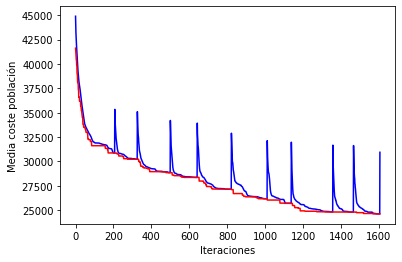

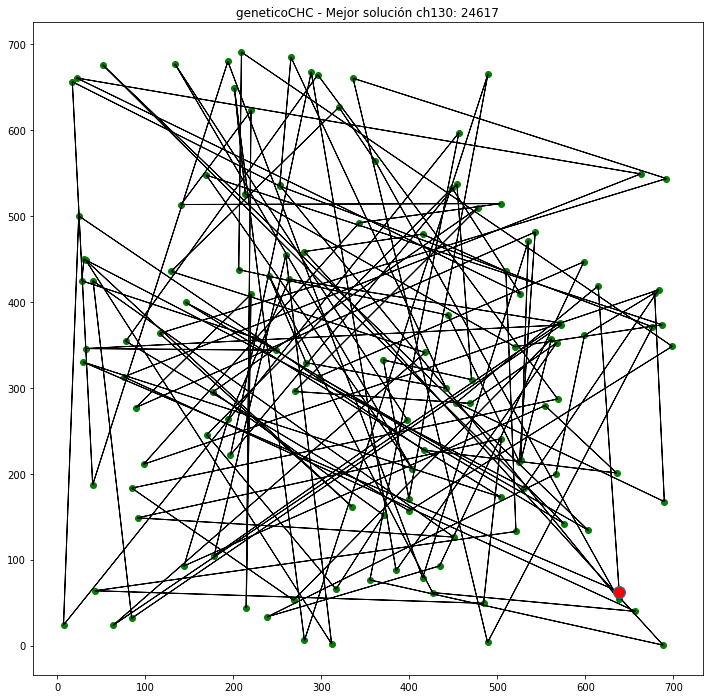

In [27]:
%matplotlib notebook
%matplotlib inline

plt.figure(figsize=(12,12)) 
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Iteraciones') ; ax.set_ylabel('Media coste población')

semilla = random.randint(0,9999999)
algoritmo = "geneticoCHC"
print(algoritmo)
fichero = "ch130"
nodos = leeFichero(fichero)
distancias = getMDistancias(nodos)
    
print(f"\nFichero: {fichero}")

costes = []
it = []
mejorSolucion = []
mejorCoste = float('inf')

# Parámetros del algoritmo
num_nodos = len(nodos)    # Fichero
tam_poblacion = 75 # 30-100 individuos
tam_mutacion_diverge = round(num_nodos * 0.35) # Variación aleatoria con respecto al individuo plantilla
sembrar_greedy = False # Plantar individuo solución algoritmo greedy
#########################

t = time.time()
# with Pool(processes=8) as p:
#         resultados = p.starmap(genetico_CHC, product([semilla], [num_nodos], [distancias], [tam_poblacion], [tam_mutacion_diverge], [sembrar_greedy], [fig], [ax]))[0]

resultados = genetico_CHC(semilla, num_nodos, distancias, tam_poblacion, tam_mutacion_diverge, sembrar_greedy, fig, ax)
    
elapsed = time.time() - t
print("Tiempo de ejecución: %f\n" % elapsed )

poblacion = resultados[0]
mejorIndividuo = min(poblacion.individuos)
mejorSolucion = mejorIndividuo.camino
coste = mejorIndividuo.coste

print("-------- PARÁMETROS A. GENÉTICO ---------")
print("Sembrar greedy:\t", sembrar_greedy)
print("Tam población:\t", tam_poblacion)
print("Tam mutación diverge:\t", tam_mutacion_diverge)
print("------------------------------------------")


print("Mejor sol Coste: %s \t #It: %i \t Semilla: %s" % (coste, resultados[1], semilla) ) 
print("-----\nCoste Media:\t%f" % poblacion.media)
print("-----\nCoste Mejor:\t%f" % coste)

xs = resultados[2]
ys = resultados[3]
ys2 = resultados[4]
plt_dynamic(fig, xs, ys, ax)
plt_dynamic(fig, xs, ys2, ax, ['r'])

titulo = algoritmo + " - Mejor solución " + fichero + ": " + str(coste)
pintaCamino(mejorSolucion, nodos, titulo)